In [19]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from subprocess import check_output
import psutil
import platform
import os
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import scipy
from scipy import stats
import sys
%matplotlib inline
print("Checking files in data location ...")
print(check_output(["ls", "../data"]).decode("utf8"))
path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent,'data')
print(data_dir)
df_clean = pd.read_csv(os.path.join(data_dir,"pr_data_clean(1h).csv"))
df_anomaly = pd.read_csv(os.path.join(data_dir,"pr_data_anomalies(80minutes).csv"))
df_audsome = pd.read_csv(os.path.join(data_dir,"pr_data_audesome_clean(1h).csv"))
df_audsome_anomaly = pd.read_csv(os.path.join(data_dir,"pr_data_audesome_anomalies(65m).csv"))
print("Clean data shape: {}".format(df_clean.shape))
print("Anomaly data shape: {}".format(df_anomaly.shape))
print("Clean AUDSOME data shape: {}".format(df_audsome.shape))
print("Anomaly AUDSOME data shape: {}".format(df_audsome_anomaly.shape))

Checking files in data location ...
logs
pr_data_anomalies(1h).csv
pr_data_anomalies(80minutes).csv
pr_data_audesome_anomalies(65m).csv
pr_data_audesome_clean(1h).csv
pr_data_clean(1h).csv
processed

/home/gabriel/Research/Aspide/workspace/v2/experiments/ede_exp/data
Clean data shape: (3600, 195)
Anomaly data shape: (4800, 195)
Clean AUDSOME data shape: (3600, 195)
Anomaly AUDSOME data shape: (3900, 195)


In [20]:
# Drop first column
df_clean.drop(["Unnamed: 0"], axis=1, inplace=True)
df_anomaly.drop(["Unnamed: 0"], axis=1, inplace=True)
df_audsome.drop(["Unnamed: 0"], axis=1, inplace=True)
df_audsome_anomaly.drop(["Unnamed: 0"], axis=1, inplace=True)

In [21]:
# df_clean
# df_anomaly

In [22]:
# Check for monotonous columns and remove them
print("Checking low variance columns ...")
print("Starting Clean dataset")
uniques = df_clean.apply(lambda x: x.nunique())
rm_columns = []
for uindex, uvalue in uniques.iteritems():
    if uvalue == 1:
        rm_columns.append(uindex)

print("Columns to be removed: {}".format(rm_columns))
print("Total: {}".format(len(rm_columns)))

uniques_a = df_anomaly.apply(lambda x: x.nunique())
rm_columns_a = []
for uindex, uvalue in uniques_a.iteritems():
    if uvalue == 1:
        rm_columns_a.append(uindex)

print("Columns to be removed: {}".format(rm_columns_a))
print("Total: {}".format(len(rm_columns_a)))

uniques_au = df_audsome.apply(lambda x: x.nunique())
rm_columns_au = []
for uindex, uvalue in uniques_au.iteritems():
    if uvalue == 1:
        rm_columns_au.append(uindex)

print("Columns to be removed: {}".format(rm_columns_au))
print("Total: {}".format(len(rm_columns_au)))

uniques_au_a = df_audsome_anomaly.apply(lambda x: x.nunique())
rm_columns_au_a = []
for uindex, uvalue in uniques_au_a.iteritems():
    if uvalue == 1:
        rm_columns_au_a.append(uindex)

print("Columns to be removed: {}".format(rm_columns_au_a))
print("Total: {}".format(len(rm_columns_au_a)))


# Check for common elements in columns
column_list = [rm_columns, rm_columns_a, rm_columns_au, rm_columns_au_a]
# result = set(column_list[0])

# Intersection of all low variance columns
drop_columns = list((set(column_list[0]).intersection(*column_list)))

# df_clean_rm =  df_clean.drop(uniques[uniques==1].index, axis=1)
df_clean_rm =  df_clean.drop(drop_columns, axis=1)
df_anomaly_rm =  df_anomaly.drop(drop_columns, axis=1)
df_audsome_rm = df_audsome.drop(drop_columns, axis=1)
df_audsome_anomaly_rm = df_audsome_anomaly.drop(drop_columns, axis=1)

print("Check shape of columns after dropping low variance ...")
print(df_clean_rm.shape)
print(df_anomaly_rm.shape)
print(df_audsome_rm.shape)
print(df_audsome_anomaly_rm.shape)
# print(df_clean_rm.columns.values)
# print(df_anomaly_rm.columns.values)
# print(df_audsome_rm.columns.values)
# print(df_audsome_anomaly_rm.columns.values)

print(set(df_clean_rm.columns.values) == set(df_anomaly_rm.columns.values))
print(set(df_anomaly_rm.columns.values) == set(df_audsome_rm.columns.values))
print(set(df_audsome_anomaly_rm.columns.values) == set(df_audsome_rm.columns.values))

Checking low variance columns ...
Starting Clean dataset
Columns to be removed: ['node_arp_entries_10.211.55.101:9100', 'node_boot_time_seconds_10.211.55.101:9100', 'node_cpu_guest_seconds_total_10.211.55.101:9100', 'node_disk_io_now_10.211.55.101:9100', 'node_disk_io_time_seconds_total_10.211.55.101:9100', 'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100', 'node_disk_read_bytes_total_10.211.55.101:9100', 'node_disk_read_time_seconds_total_10.211.55.101:9100', 'node_disk_reads_completed_total_10.211.55.101:9100', 'node_disk_reads_merged_total_10.211.55.101:9100', 'node_disk_write_time_seconds_total_10.211.55.101:9100', 'node_disk_writes_completed_total_10.211.55.101:9100', 'node_disk_writes_merged_total_10.211.55.101:9100', 'node_disk_written_bytes_total_10.211.55.101:9100', 'node_exporter_build_info_10.211.55.101:9100', 'node_filefd_maximum_10.211.55.101:9100', 'node_filesystem_device_error_10.211.55.101:9100', 'node_filesystem_files_10.211.55.101:9100', 'node_filesystem_f

In [23]:
#Save processed
processed_dir = os.path.join(data_dir,'processed')
print(processed_dir)
df_clean_rm.to_csv(os.path.join(processed_dir, 'clean.csv'), index=False)
df_anomaly_rm.to_csv(os.path.join(processed_dir, 'anomaly.csv'), index=False)
df_audsome_rm.to_csv(os.path.join(processed_dir, 'audesome_clearn.csv'), index=False)
df_audsome_anomaly_rm.to_csv(os.path.join(processed_dir, 'audsome_anomaly.csv'), index=False)



/home/gabriel/Research/Aspide/workspace/v2/experiments/ede_exp/data/processed


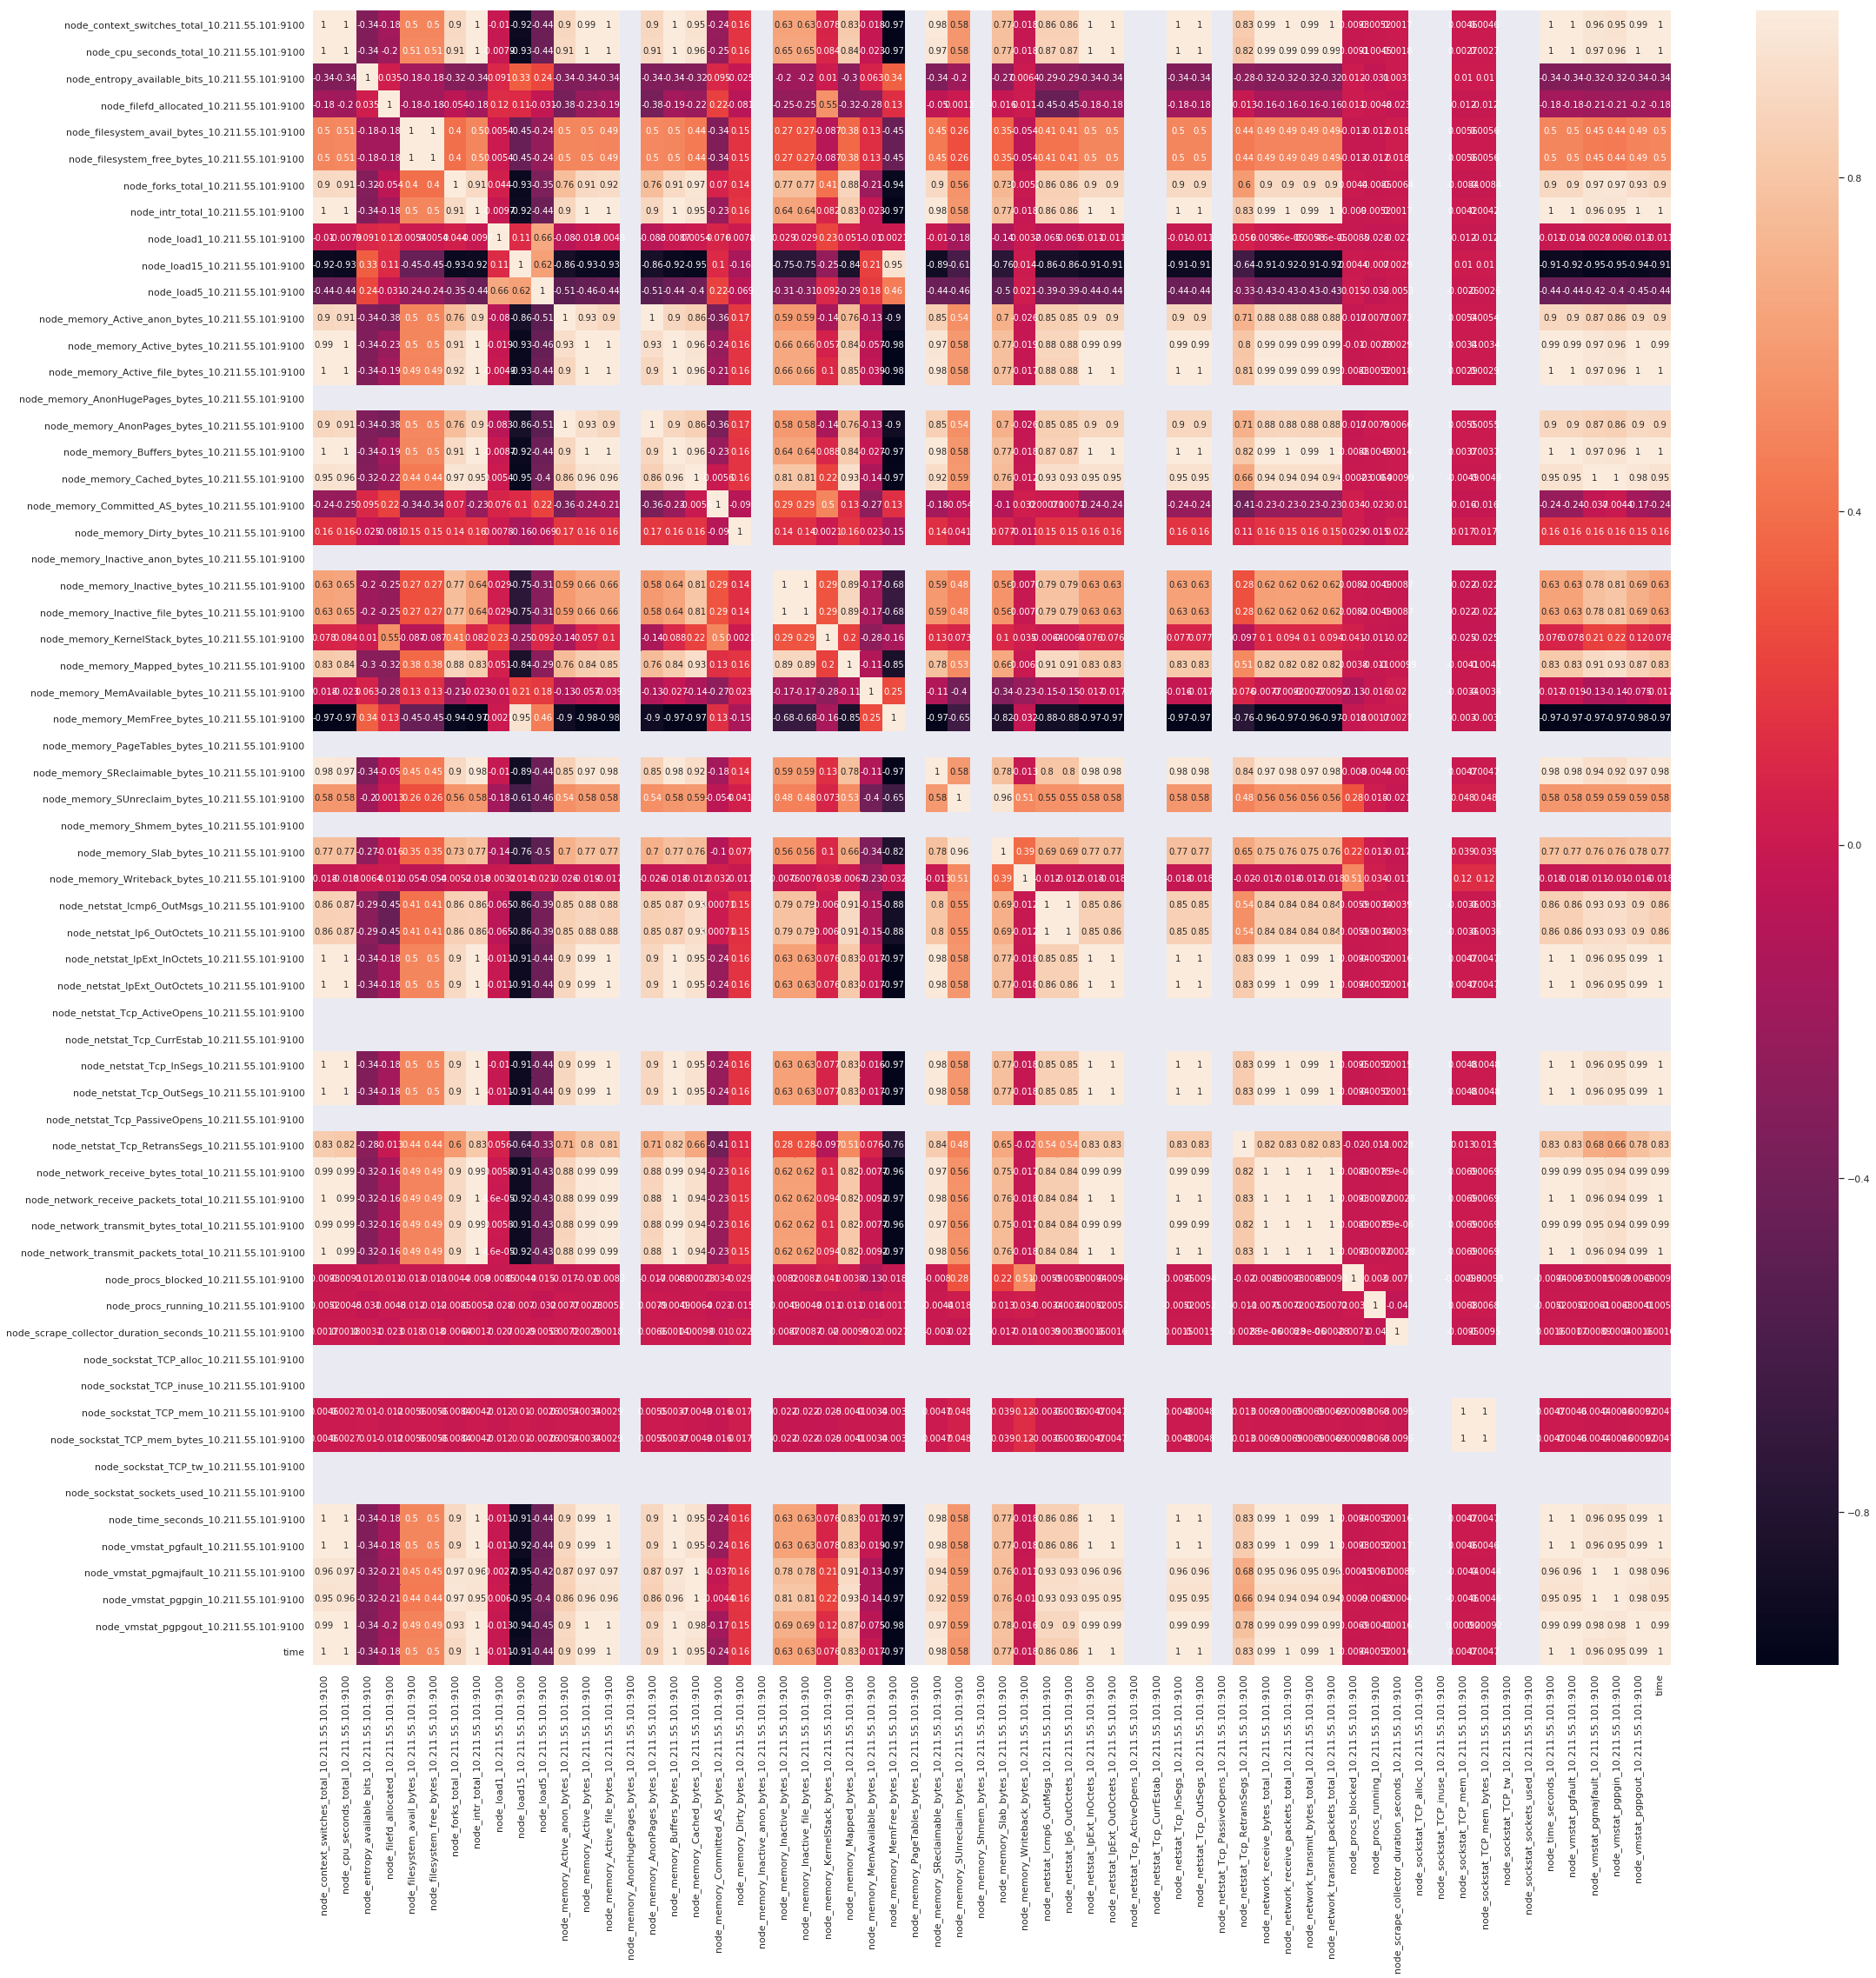

In [24]:
# Pearson correlation
plt.subplots(figsize=(35, 35))
sns.heatmap(df_clean_rm.corr(), annot=True)
plt.show()

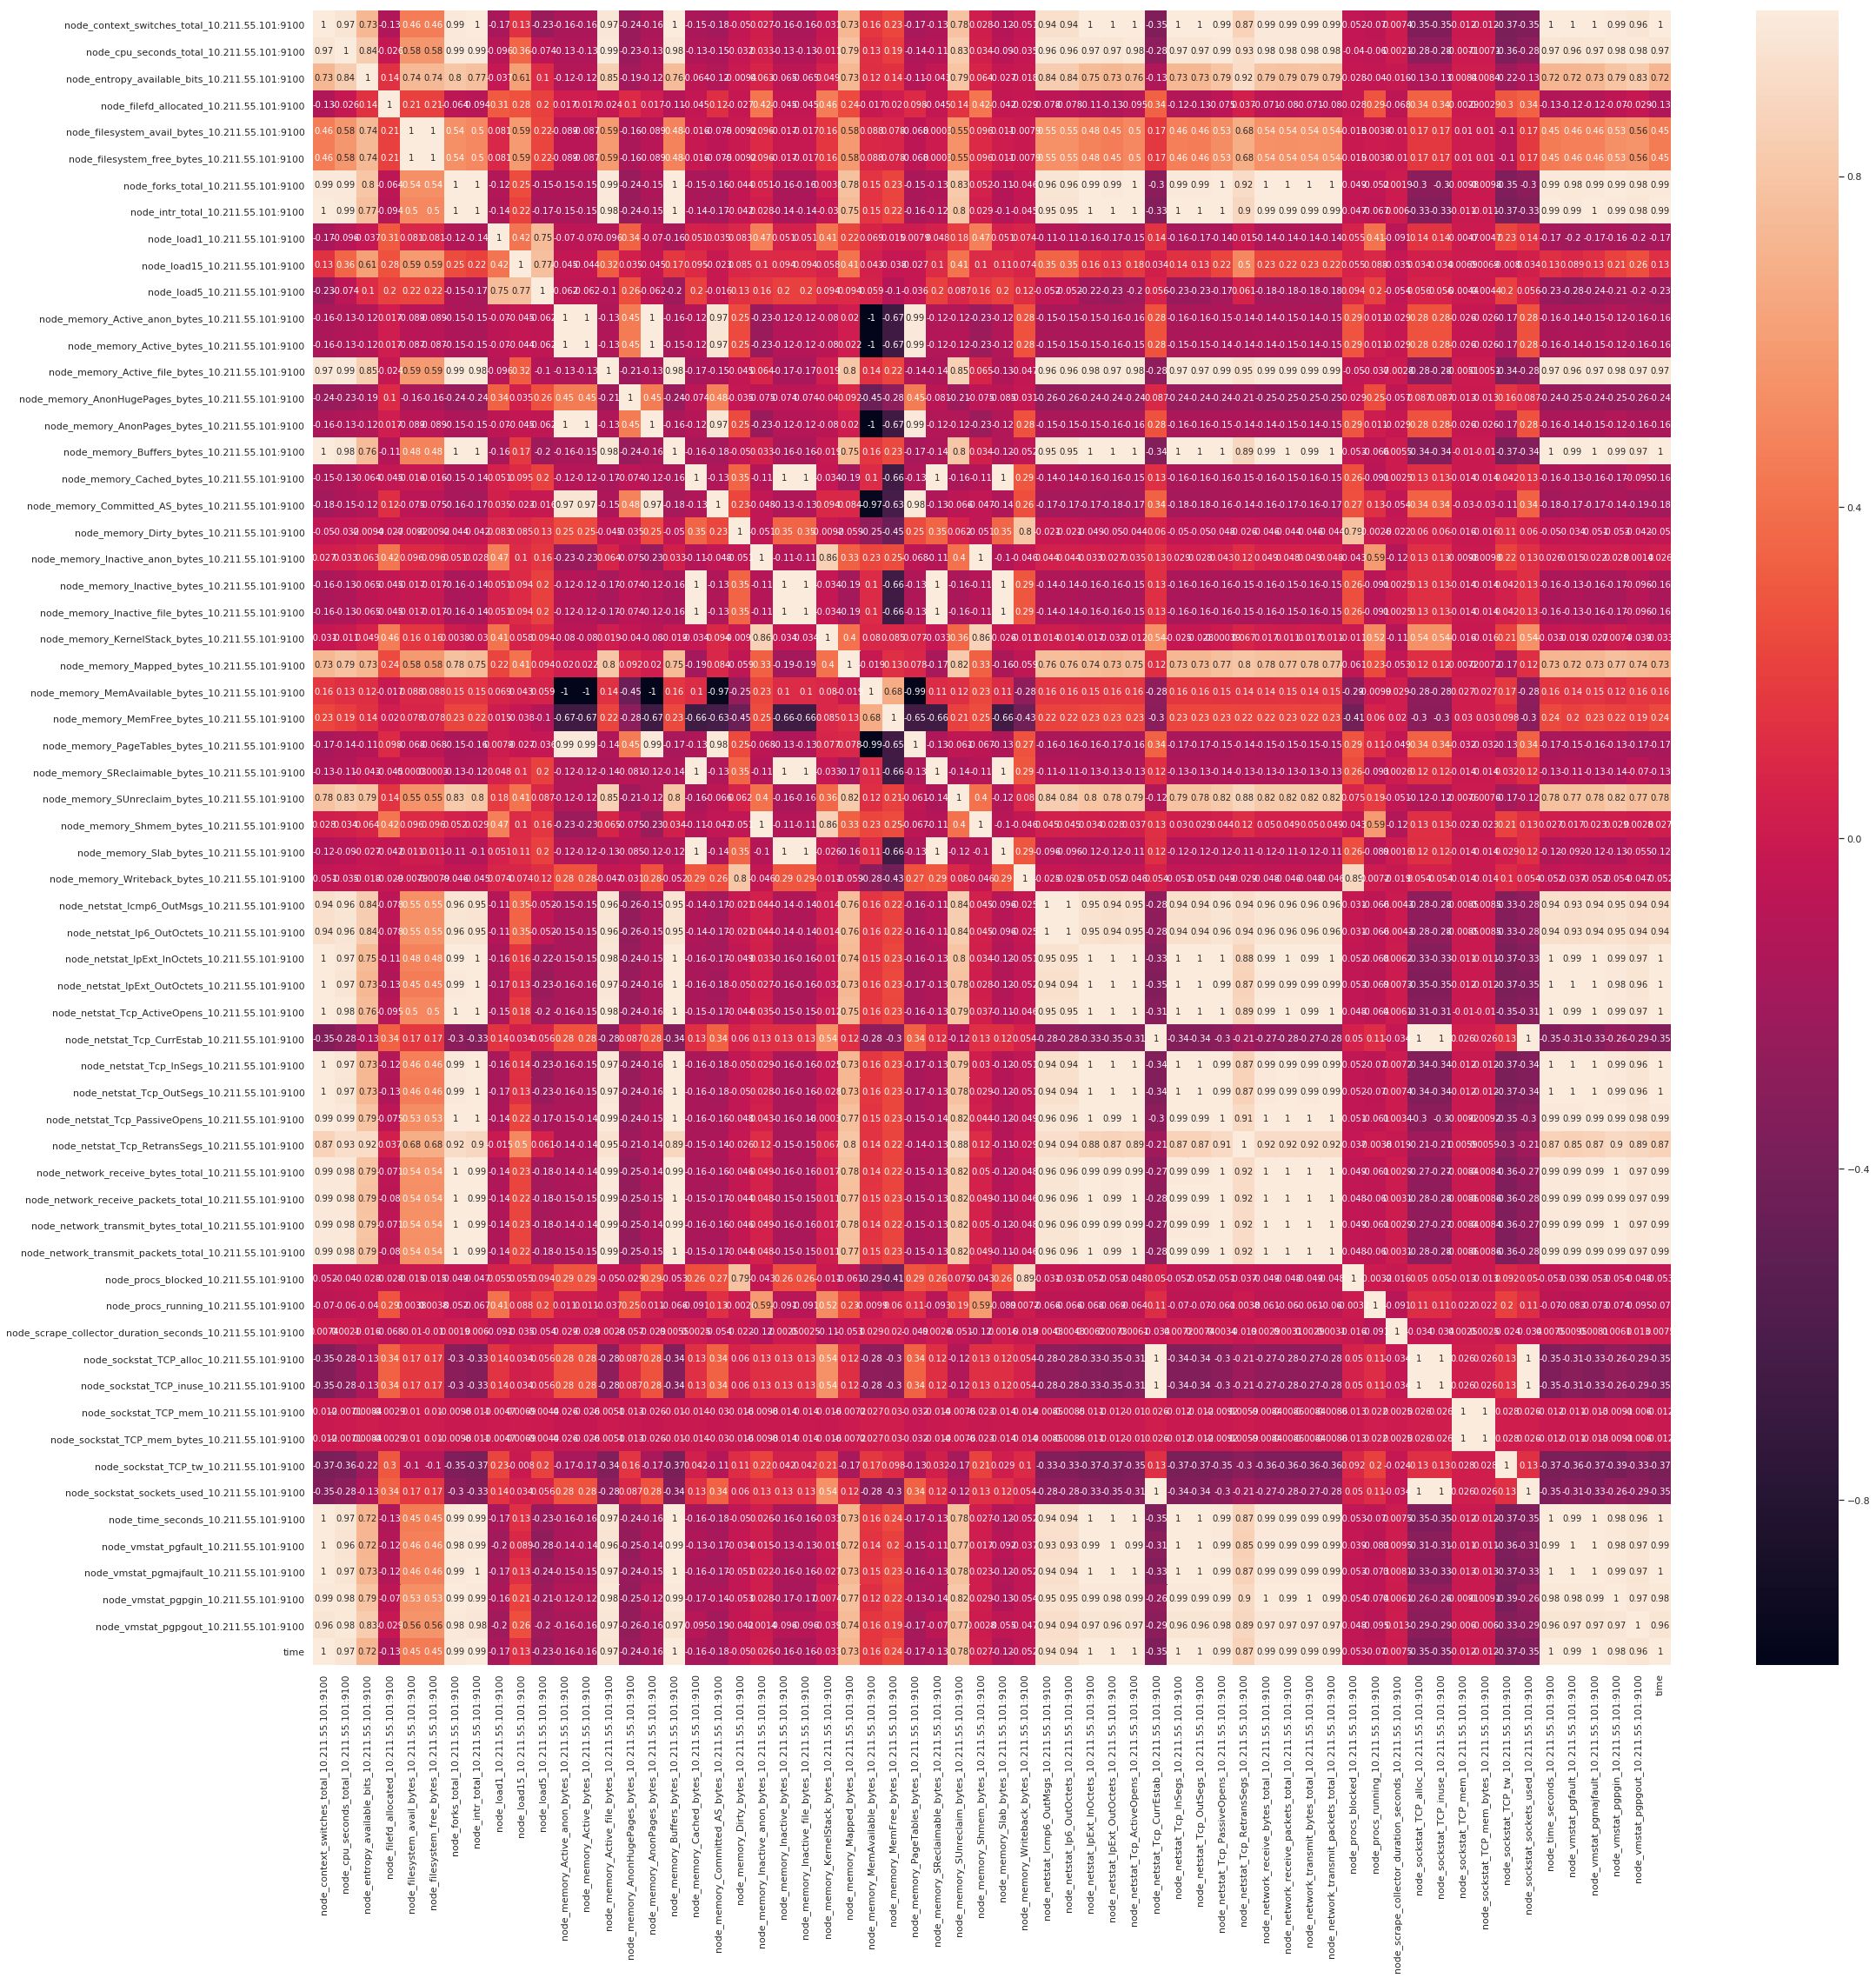

In [25]:
plt.subplots(figsize=(35, 35))
sns.heatmap(df_anomaly_rm.corr(), annot=True)
plt.show()

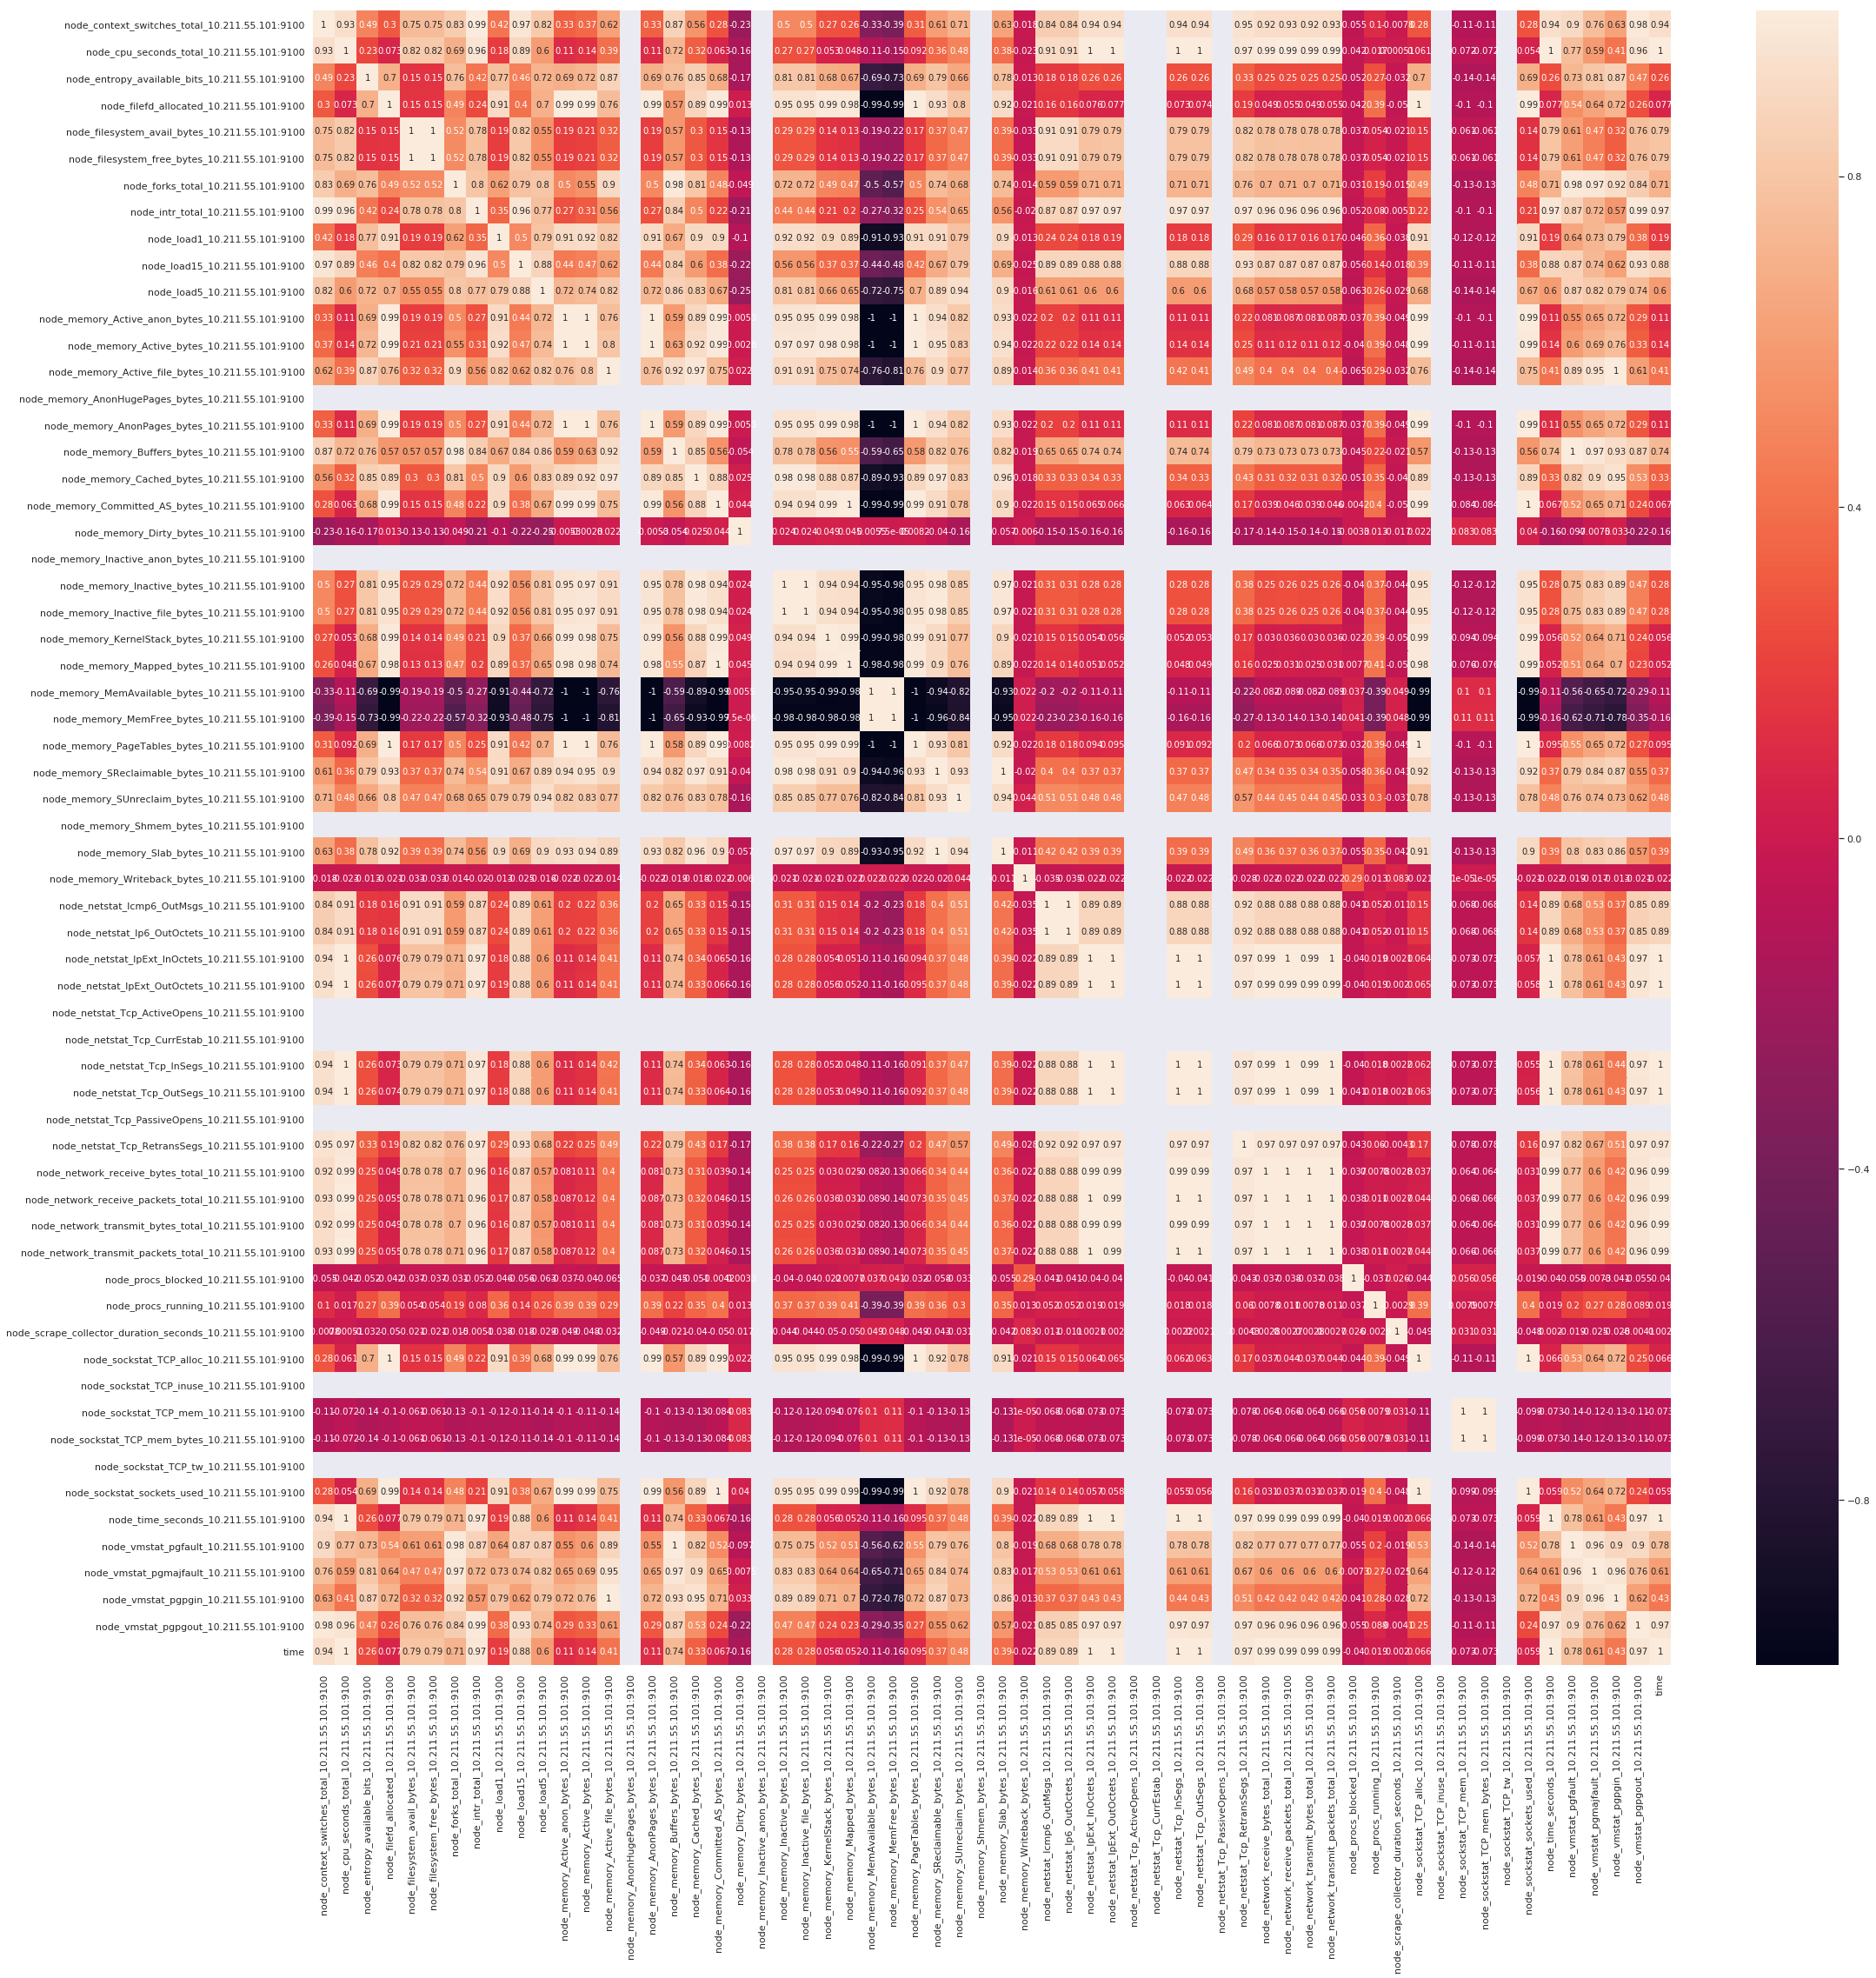

In [26]:
plt.subplots(figsize=(35, 35))
sns.heatmap(df_audsome_rm.corr(), annot=True)
plt.show()

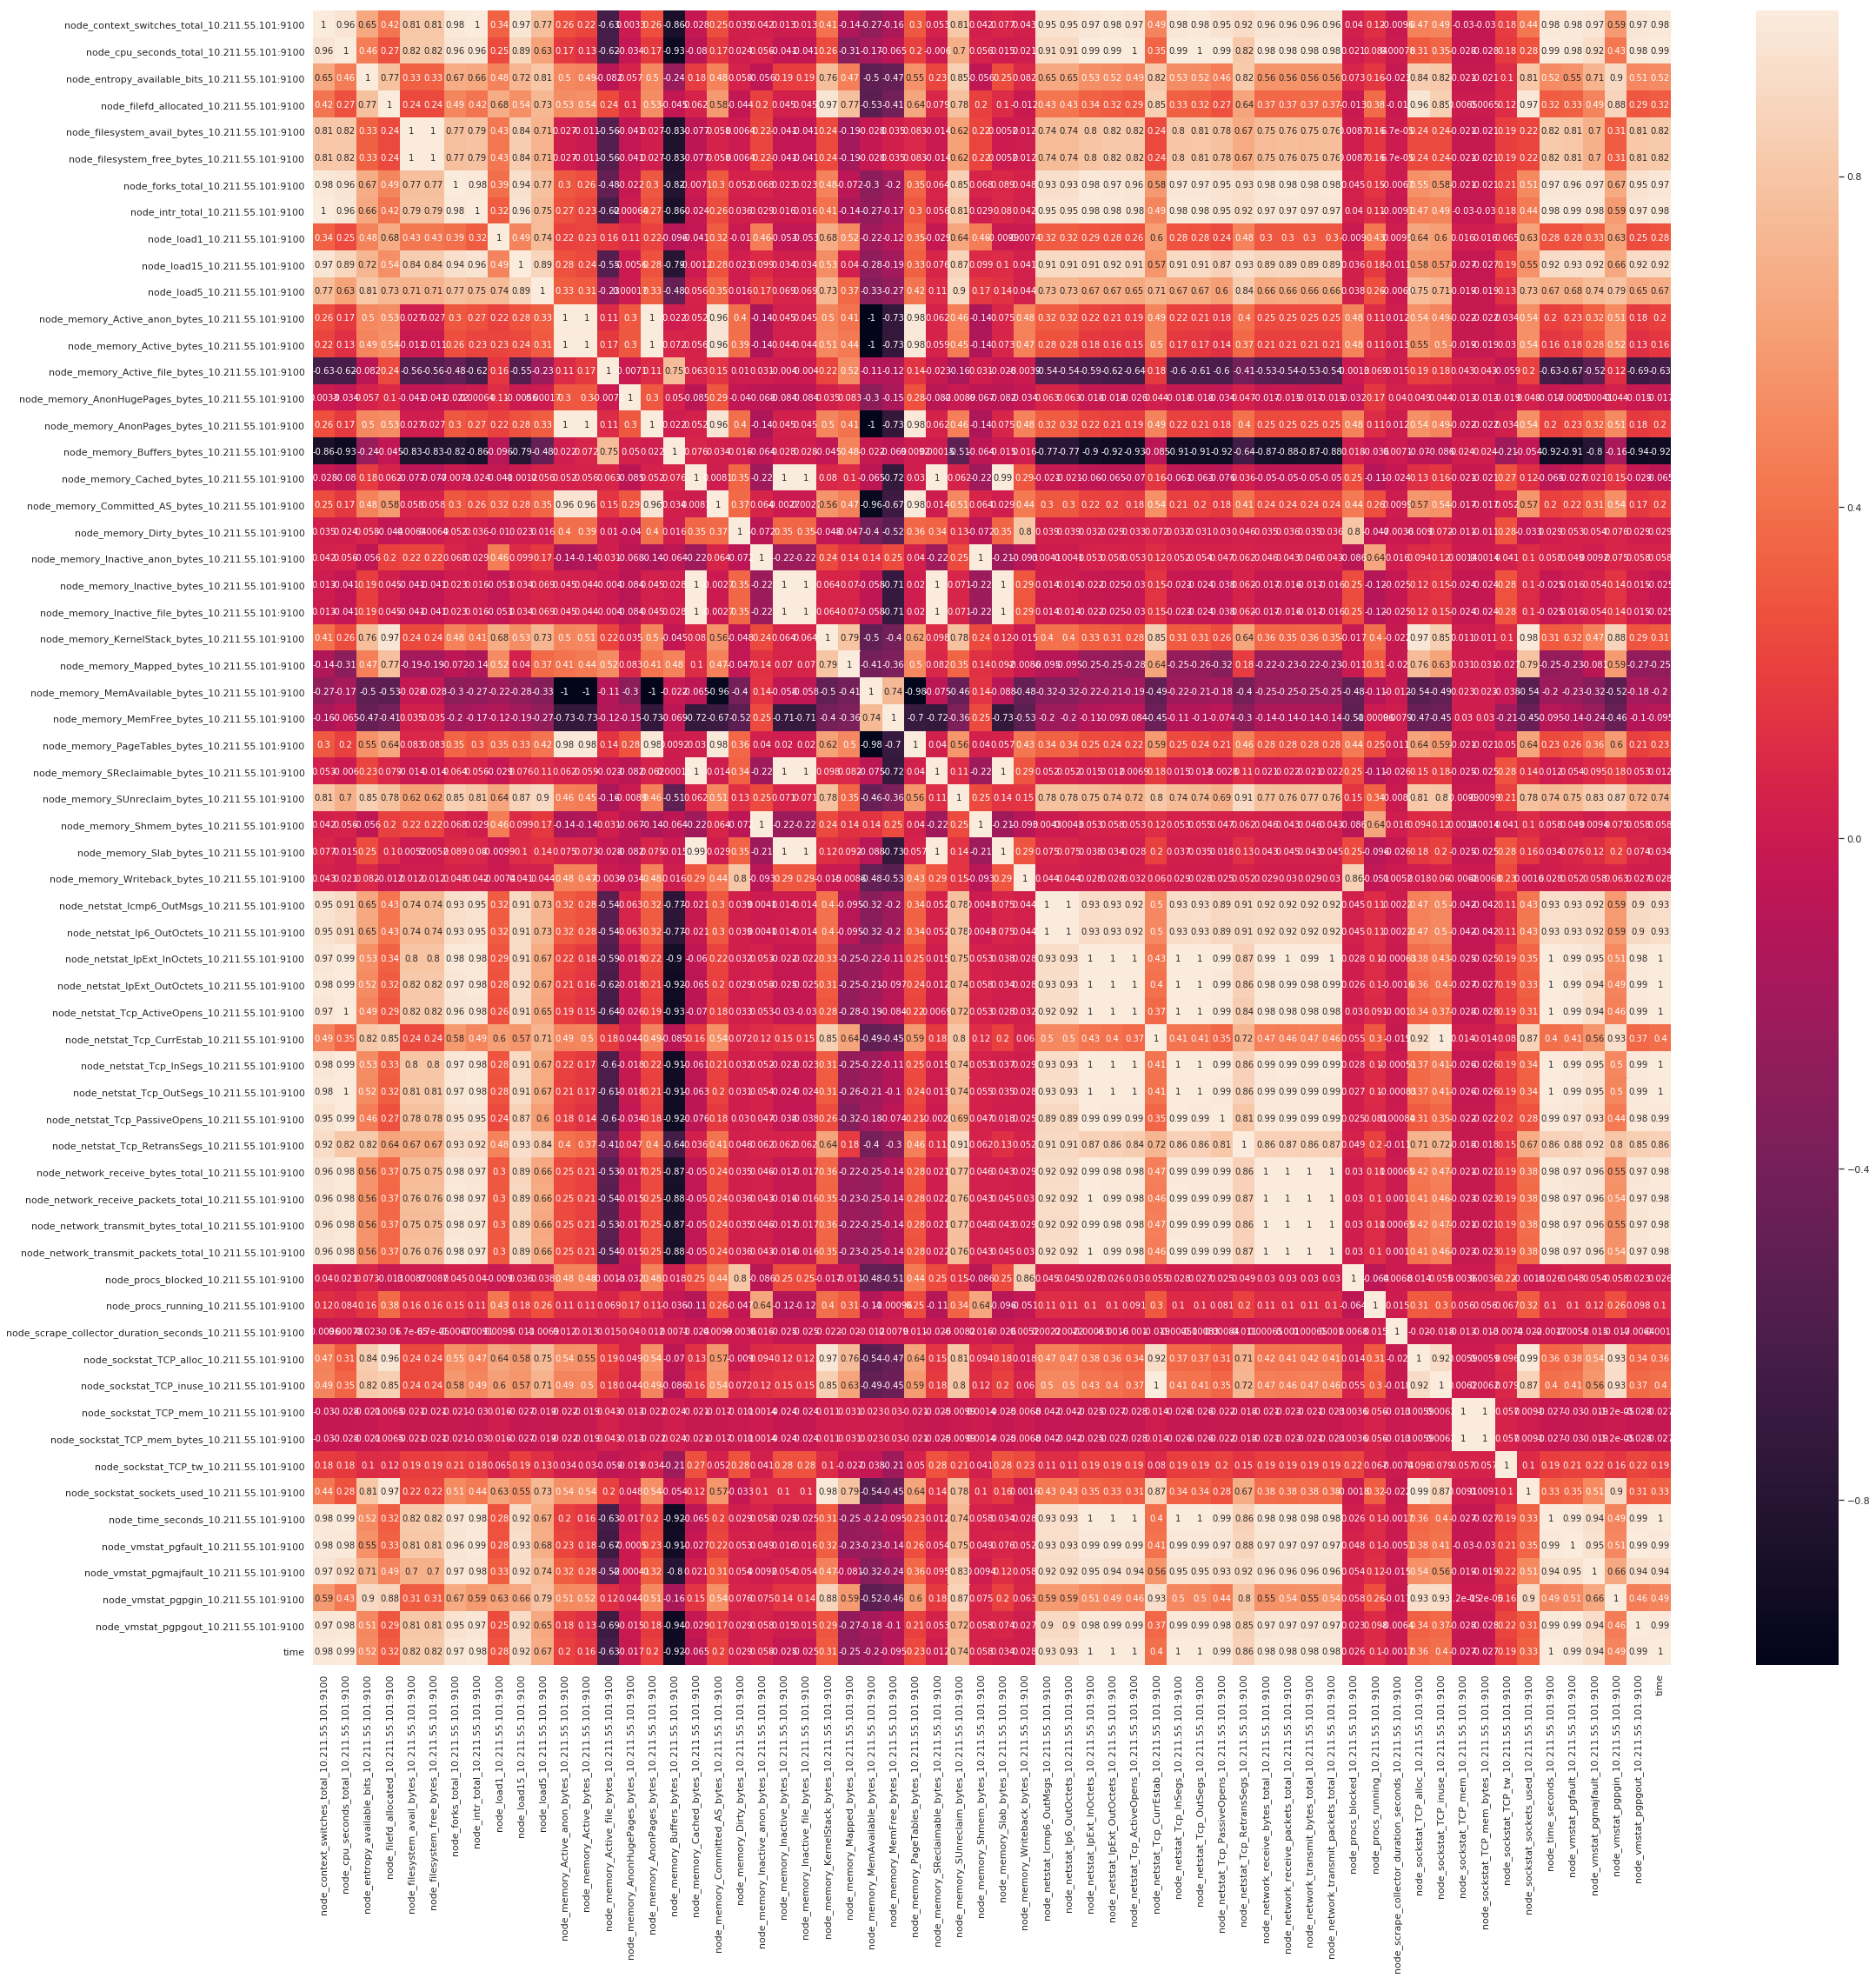

In [27]:
plt.subplots(figsize=(35, 35))
sns.heatmap(df_audsome_anomaly_rm.corr(), annot=True)
plt.show()

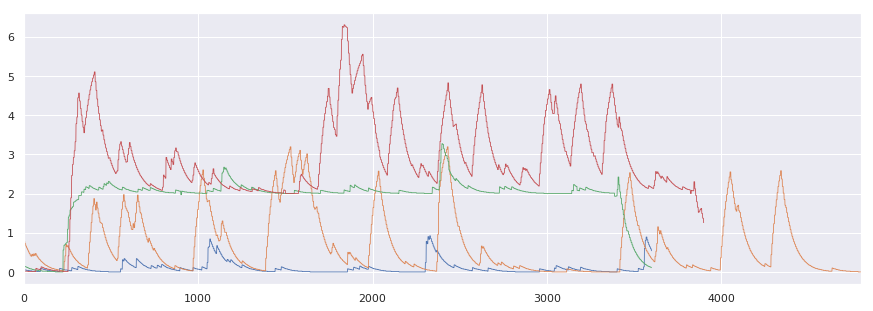

In [28]:
# Plots
# DF: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
# Single plot
sns.set(rc={'figure.figsize':(15, 5)})
df_clean_rm["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
df_anomaly_rm["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_rm["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_anomaly_rm["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
cols_p_t = ["node_load1_10.211.55.101:9100", "node_load5_10.211.55.101:9100", "node_load15_10.211.55.101:9100"]

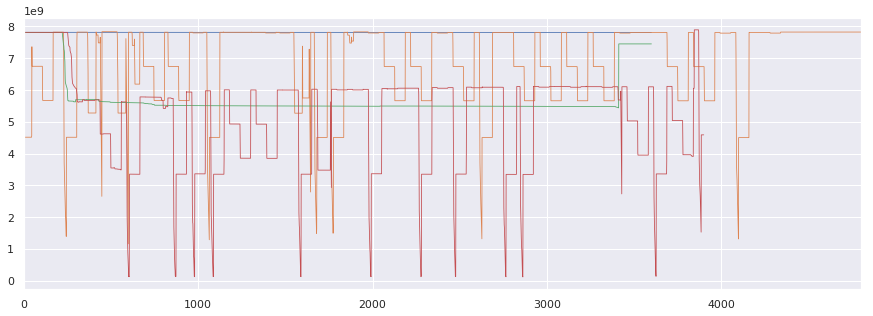

In [30]:
sns.set(rc={'figure.figsize':(15, 5)})
df_clean_rm["node_memory_MemFree_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_anomaly_rm["node_memory_MemFree_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_rm["node_memory_MemFree_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_anomaly_rm["node_memory_MemFree_bytes_10.211.55.101:9100"].plot(linewidth=0.8)

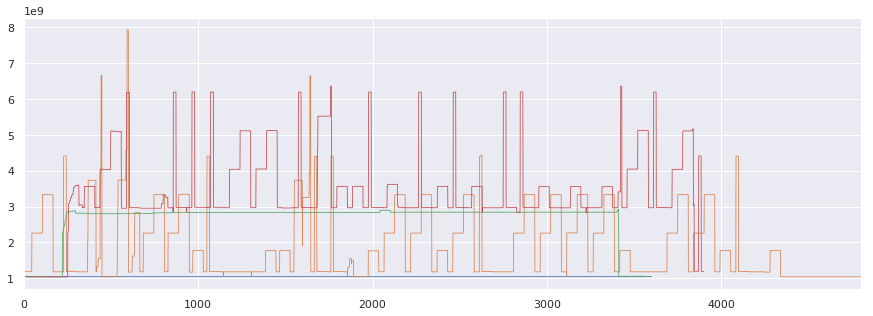

In [32]:
sns.set(rc={'figure.figsize':(15, 5)})
df_clean_rm["node_memory_Committed_AS_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_anomaly_rm["node_memory_Committed_AS_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_rm["node_memory_Committed_AS_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_anomaly_rm["node_memory_Committed_AS_bytes_10.211.55.101:9100"].plot(linewidth=0.8)

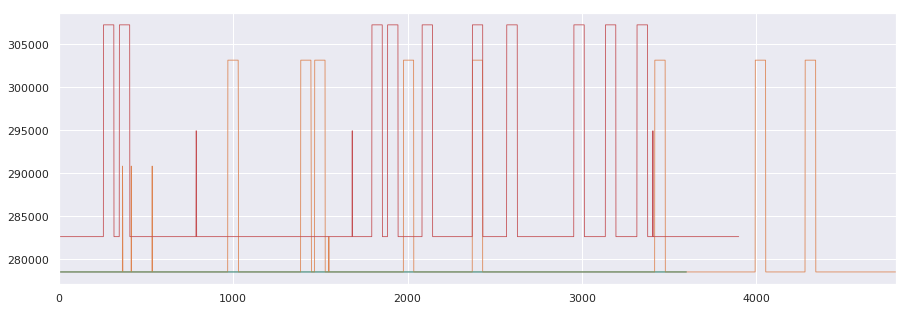

In [34]:
sns.set(rc={'figure.figsize':(15, 5)})
df_clean_rm["node_memory_Inactive_anon_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_anomaly_rm["node_memory_Inactive_anon_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_rm["node_memory_Inactive_anon_bytes_10.211.55.101:9100"].plot(linewidth=0.8)
df_audsome_anomaly_rm["node_memory_Inactive_anon_bytes_10.211.55.101:9100"].plot(linewidth=0.8)

In [ ]:
# Trends
sns.set(rc={'figure.figsize':(15, 5)})
sns.lmplot(y="node_load1_10.211.55.101:9100", x="time", data=df_anomaly_rm);

In [ ]:
axes = df_clean_rm[cols_p_t].plot(marker='.', alpha=0.5, figsize=(11, 9), subplots=True)
# i = 1
# for ax in axes:
#     ax.set_ylabel("CPU load {}".format(i))
#     print(ax.name)
#     i += 4

In [ ]:
# all_cols = df_clean_rm.columns.values
# df_clean_rm[list(all_cols)].plot(marker='.', alpha=0.5, figsize=(20, 15), subplots=True)